In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io import shapereader
import seaborn as sns
from geopy.distance import geodesic

def merge_cyclone_sst(cyclone_path, sst_path,output_file_path):
    file_path = cyclone_path
    data = pd.read_csv(file_path)

    # labeling cyclone
    data['Cycl_Seq'] = None
    current_number = data.iloc[0]['No. of Cycl']
    sequence_number = 1
    data.at[0, 'Cycl_Seq'] = sequence_number
    for i in range(1, len(data)):
        if data.at[i, 'No. of Cycl'] != current_number:
            sequence_number += 1
            current_number = data.at[i, 'No. of Cycl']
        data.at[i, 'Cycl_Seq'] = sequence_number

    data['No. of Cycl'] = data['Cycl_Seq']
    data.rename(columns={'No. of Cycl': 'No_cyclone'}, inplace=True)
    data.drop(columns=['Cycl_Seq'], inplace=True)

    # change latitude to negetive (southern hemisphere coordinates)
    data['lat_tenth'] = -data['lat_tenth']

    # new time format
    data['Year'] = data['Time'].astype(str).str[:4]
    data['Month'] = data['Time'].astype(str).str[4:6]
    data['Hour'] = data['Time'].astype(str).str[8:]
    data['New_Time'] = pd.to_datetime(data['Year'] + '-' + data['Month'] + '-01 ' + data['Hour'] + ':00:00')
    data['Time'] = data['Time'].astype(str)

    def extract_season(time_str):
        month = int(time_str[4:6])
        if month in [12, 1, 2]:
            season = 'DJF'
        elif month in [3, 4, 5]:
            season = 'MAM'
        elif month in [6, 7, 8]:
            season = 'JJA'
        else:
            season = 'SON'
        return season

    data['Season'] = data['Time'].map(extract_season)

    # create saffir simpson category column
    def categorize_saffir_simpson(speed):
        if speed < 82:
            return 1
        elif 82 <= speed < 95:
            return 2
        elif 95 <= speed < 112:
            return 3
        elif 112 <= speed < 136:
            return 4
        else:
            return 5

    data['Saffir-Simpson_Category'] = data['Speed(knots)'].apply(categorize_saffir_simpson)

    # load netCDF file
    nc_data = xr.open_dataset(sst_path)
    data['New_Time'] = pd.to_datetime(data['New_Time'])
    sst_values = []
    for index, row in data.iterrows():
        # extract the time, latitude, and longitude
        time = row['New_Time']
        lat = row['lat_tenth']
        lon = row['lon_tenth']

        # nc info
        time_index = nc_data.time.sel(time=time, method='nearest').time
        lat_index = nc_data.latitude.sel(latitude=lat, method='nearest').latitude
        lon_index = nc_data.longitude.sel(longitude=lon, method='nearest').longitude

        # match
        sst_value = nc_data.sst.sel(time=time_index, latitude=lat_index, longitude=lon_index, method='nearest').values
        sst_values.append(sst_value[0] if sst_value.size > 0 else float('nan'))

    data['SST'] = sst_values

    sst = nc_data['sst']
    lats = nc_data['latitude']
    lons = nc_data['longitude']
    def find_nearest(array, value):
        idx = (np.abs(array - value)).argmin()
        return idx

    avg_sst = []
    for index, row in data.iterrows():
        lat_idx = find_nearest(lats, row['lat_tenth'])
        lon_idx = find_nearest(lons, row['lon_tenth'])
        try:
            avg_sst_value = sst.sel(latitude=lats[lat_idx], longitude=lons[lon_idx], method="nearest").mean().item()
        except IndexError:
            avg_sst_value = np.nan  # Handle the case where the index is out of bounds
        avg_sst.append(avg_sst_value)

    data['avsst'] = avg_sst
    data['RSST'] = data['SST']-data['avsst']
    # save file
    data.to_csv(output_file_path, index=False)

In [2]:
merge_cyclone_sst('D:/pythonfile/cyclone/South_indian_hurricane.csv','D:/pythonfile/cyclone/SI_SST.nc','D:/pythonfile/cyclone/Updated_South_indian_hurricane_with_SST.csv')

In [7]:
def plot_cyclone_tracks_cartopy(path):
    data = pd.read_csv(path)

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_global()

    # Remove the etopo data, using a simple feature for demonstration
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.OCEAN, facecolor='aqua')
    ax.add_feature(cfeature.LAND, facecolor='coral')
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.LAKES, facecolor='aqua')
    ax.set_extent([30, 130, -50, 20], crs=ccrs.PlateCarree())

    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
                      xlocs=range(30, 130, 5), ylocs=range(-50, 20, 5))
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    for cyclone_id in data['No_cyclone'].unique():
        track = data[data['No_cyclone'] == cyclone_id]
        ax.plot(track['lon_tenth'], track['lat_tenth'], linewidth=0.5, color='red', transform=ccrs.Geodetic())

    ax.text(80, -5, "Indian Ocean", transform=ccrs.PlateCarree(), fontsize=12, verticalalignment='center',
            horizontalalignment='right')

    plt.title("Cyclone Tracks in the South Indian Basin")
#     plt.savefig('D:/pythonfile/cyclone/figure/cyclone_tracks_map.png', format='png', dpi=300)
    plt.show()

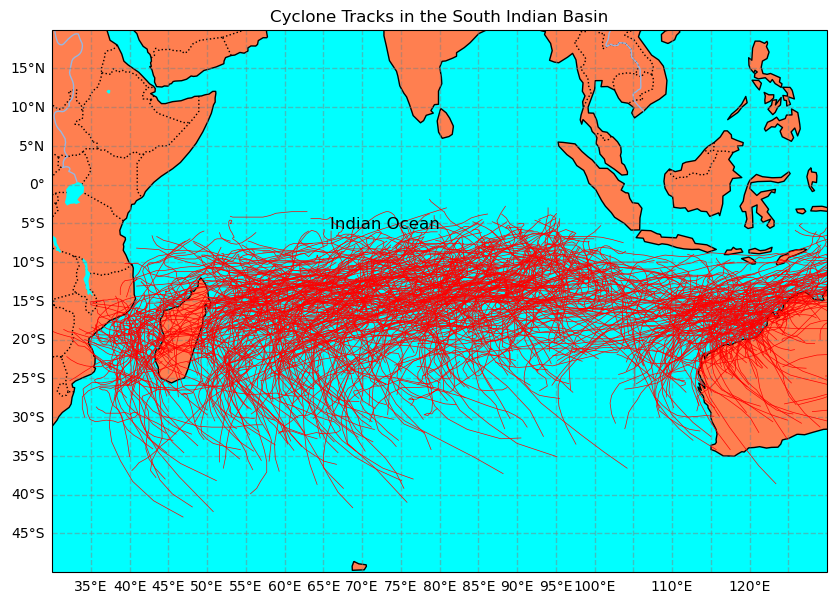

In [8]:
plot_cyclone_tracks_cartopy('D:/pythonfile/cyclone/Updated_South_indian_hurricane_with_SST.csv')

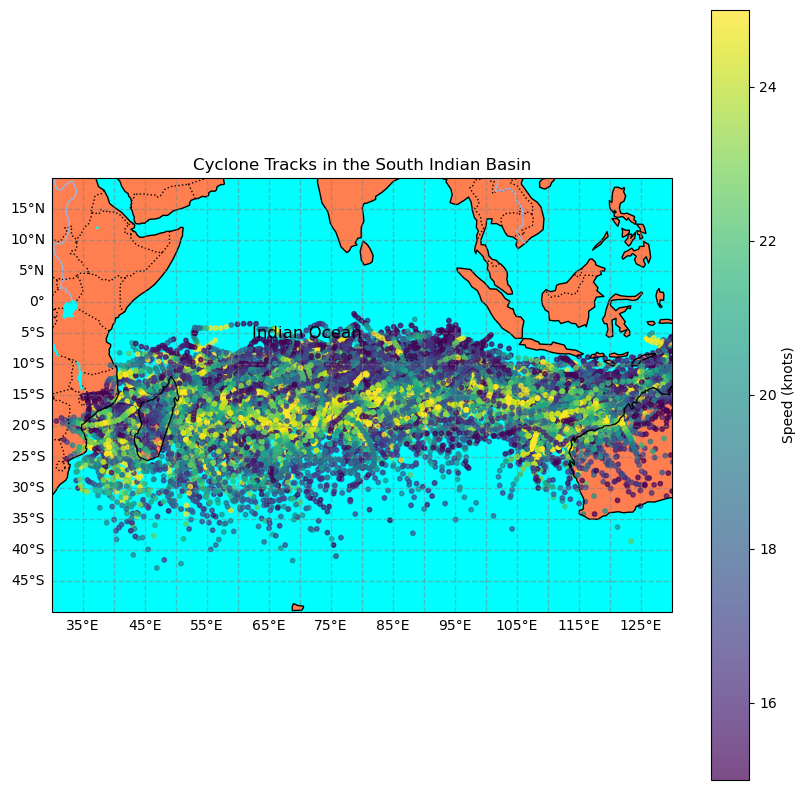

In [10]:
data = pd.read_csv('D:/pythonfile/cyclone/Updated_South_indian_hurricane_with_SST.csv')

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()

# Remove the etopo data, using a simple feature for demonstration
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.OCEAN, facecolor='aqua')
ax.add_feature(cfeature.LAND, facecolor='coral')
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAKES, facecolor='aqua')
ax.set_extent([30, 130, -50, 20], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
                  xlocs=range(30, 130, 5), ylocs=range(-50, 20, 5))
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

for cyclone_id in data['No_cyclone'].unique():
    track = data[data['No_cyclone'] == cyclone_id]
    scatter = ax.scatter(track['lon_tenth'], track['lat_tenth'], c=track['Speed(knots)'], cmap='viridis',
                         s=10, transform=ccrs.PlateCarree(), label=f'Cyclone {cyclone_id}', alpha=0.7)

ax.text(80, -5, "Indian Ocean", transform=ccrs.PlateCarree(), fontsize=12, verticalalignment='center',
            horizontalalignment='right')

plt.colorbar(scatter, ax=ax, orientation='vertical', label='Speed (knots)')
plt.title("Cyclone Tracks in the South Indian Basin")
plt.show()

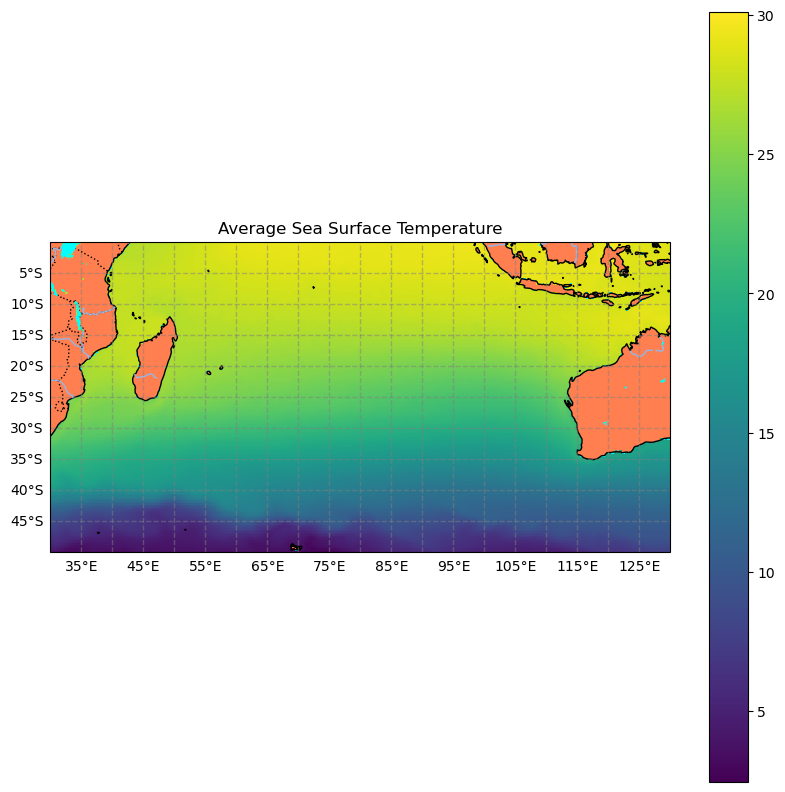

In [11]:
def plot_sst_SI(path):
    # calculate the SST over all region in South India Ocean
    ds = xr.open_dataset(path)
    mean_sst = ds['sst'].mean(dim=['time', 'expver'])
    mean_sst = mean_sst - 273.15

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.OCEAN, facecolor='aqua')
    ax.add_feature(cfeature.LAND, facecolor='coral')
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.LAKES, facecolor='aqua')
    ax.set_extent([30, 130, -50, 0], crs=ccrs.PlateCarree())

    sst_plot = ax.pcolormesh(ds['longitude'], ds['latitude'], mean_sst,
                             shading='auto', transform=ccrs.PlateCarree())

    plt.colorbar(sst_plot, ax=ax, orientation='vertical')

    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
                      xlocs=range(30, 130, 5), ylocs=range(-50, 20, 5))
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    plt.title('Average Sea Surface Temperature')
    plt.show()

# use this function to generate a new csv file
plot_sst_SI('D:/pythonfile/cyclone/SI_SST.nc')

C:\Users\16962\AppData\Local\Temp\ipykernel_36080\3369382188.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_avg_sst = filtered_data_df.groupby(filtered_data_df['time'].dt.to_period('M')).mean()['sst']
C:\Users\16962\AppData\Local\Temp\ipykernel_36080\3369382188.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_avg_sst = filtered_data_df.groupby(filtered_data_df['time'].dt.to_period('M')).mean()['sst']
C:\Users\16962\AppData\Local\Temp\ipykernel_36080\3369382188.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeri

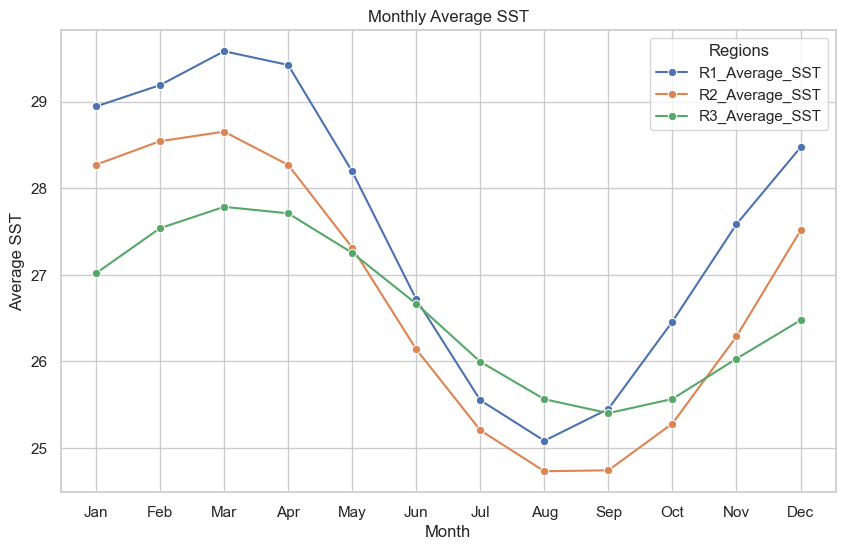

In [12]:
def plot_month_sst_3r(path_csv,path_fig,path1,path2,path3):

    def csvdata_region_month_sst(path_in, path_out, max_long, low_long, max_lat, low_lat):
        ds = xr.open_dataset(path_in)
        times = pd.to_datetime(ds['time'].values)
        data = times[times == times.normalize()]
        dataset = ds.sel(time=data)

        filtered_data = dataset.where(
            (dataset['longitude'] >= low_long) & (dataset['longitude'] <= max_long) &
            (dataset['latitude'] >= low_lat) & (dataset['latitude'] <= max_lat), drop=True
        )
        filtered_data_df = filtered_data.to_dataframe().reset_index()
        filtered_data_df['time'] = pd.to_datetime(filtered_data_df['time'])

        monthly_avg_sst = filtered_data_df.groupby(filtered_data_df['time'].dt.to_period('M')).mean()['sst']
        monthly_avg_sst_df = monthly_avg_sst.reset_index()
        monthly_avg_sst_df.columns = ['Date', 'Average_SST']
        monthly_avg_sst_df.to_csv(path_out, index=False)

        data = pd.read_csv(path_out)
        data['Date'] = pd.to_datetime(data['Date'])
        data['Month_only'] = data['Date'].dt.month
        monthly_avg_sst = data.groupby('Month_only')['Average_SST'].mean().reset_index()
        monthly_avg_sst.columns = ['Month', 'Average_SST']
        monthly_avg_sst['Average_SST'] = monthly_avg_sst['Average_SST'] - 273.15
        monthly_avg_sst.to_csv(path_out, index=False)

    csvdata_region_month_sst('D:/pythonfile/cyclone/SI_SST.nc', path1, 120, 115, -15,
                             -20)
    csvdata_region_month_sst('D:/pythonfile/cyclone/SI_SST.nc', path2, 65, 55, -10,
                             -20)
    csvdata_region_month_sst('D:/pythonfile/cyclone/SI_SST.nc', path3, 105, 95, -10,
                             -20)

    data1 = pd.read_csv(path1,usecols=['Month','Average_SST'])
    data2 = pd.read_csv(path2,usecols=['Average_SST'])
    data3 = pd.read_csv(path3, usecols=['Average_SST'])

    data1 = data1.rename(columns={'Average_SST': 'average_sst_r1'})
    data2 = data2.rename(columns={'Average_SST': 'average_sst_r2'})
    data3 = data3.rename(columns={'Average_SST': 'average_sst_r3'})

    combined_data = pd.concat([data1,data2,data3], axis=1)
    combined_data.to_csv(path_csv, index=False)

    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Month', y='average_sst_r1', data=combined_data, marker='o', label='R1_Average_SST')
    sns.lineplot(x='Month', y='average_sst_r2', data=combined_data, marker='o', label='R2_Average_SST')
    sns.lineplot(x='Month', y='average_sst_r3', data=combined_data, marker='o', label='R3_Average_SST')

    plt.xticks(ticks=range(1, 13), labels=[
        'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    plt.title('Monthly Average SST')
    plt.xlabel('Month')
    plt.ylabel('Average SST')
    plt.legend(title='Regions')
    plt.savefig(path_fig, format='png', dpi=300)
    plt.show()

# use this function to generate new csv files and figure
plot_month_sst_3r('D:/pythonfile/cyclone/monthsst_allr.csv','D:/pythonfile/cyclone/figure/SI_monthsst_3region.png','D:/pythonfile/cyclone/monthsst_r1.csv','D:/pythonfile/cyclone/monthsst_r2.csv','D:/pythonfile/cyclone/monthsst_r3.csv')

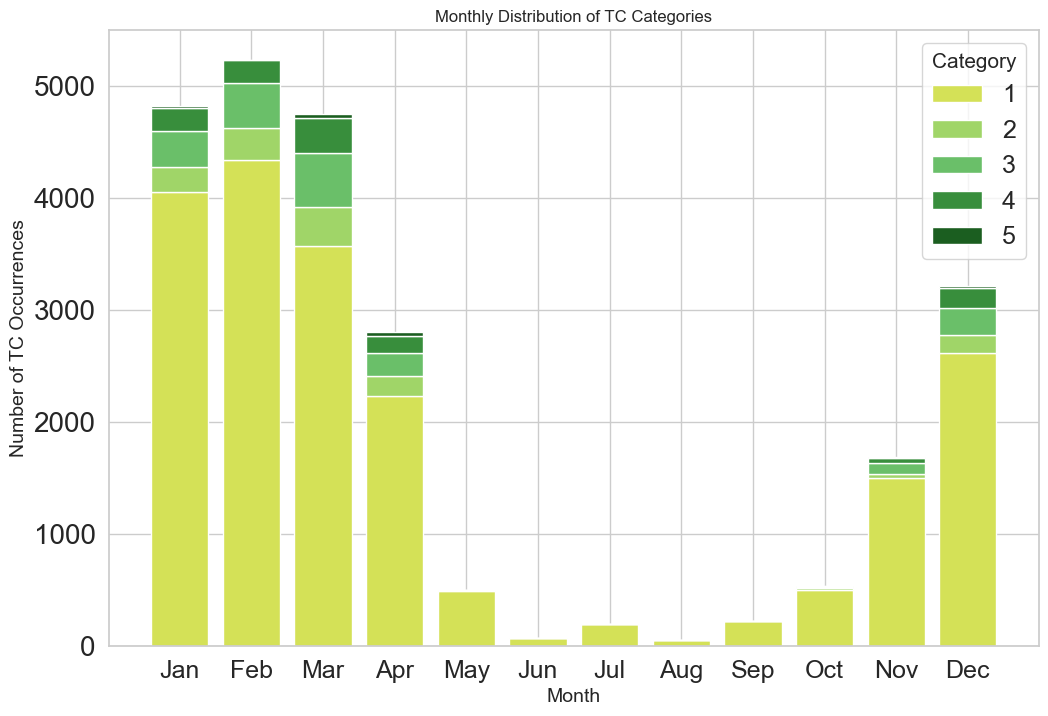

In [13]:
def plot_month_category(path_in, fig_out):
    data = pd.read_csv(path_in)

    data_filtered = data[['Month', 'Saffir-Simpson_Category']]
    data_grouped = data_filtered.groupby(['Month', 'Saffir-Simpson_Category']).size().unstack(fill_value=0)
    colors = ['#d4e157', '#a0d568', '#6abf69', '#388e3c', '#1b5e20']
    fig, ax = plt.subplots(figsize=(12, 8))
    bar_width = 0.8  # 设置柱状宽度
    bottom = None

    for category, color in zip(data_grouped.columns, colors):
        if bottom is None:
            bottom = data_grouped[category]
            ax.bar(data_grouped.index, data_grouped[category], label=category, color=color, width=bar_width)
        else:
            ax.bar(data_grouped.index, data_grouped[category], label=category, color=color, bottom=bottom, width=bar_width)
            bottom += data_grouped[category]

    plt.title('Monthly Distribution of TC Categories')
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Number of TC Occurrences', fontsize=14)
    plt.xticks(ticks=range(1, 13), labels=[
        'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=18)
    plt.yticks(fontsize=20)
    plt.legend(title='Category', title_fontsize='15', fontsize='18')

    plt.savefig(fig_out, format='png', dpi=300)
    plt.show()

# use this function to generate polt
plot_month_category('D:/pythonfile/cyclone/Updated_South_indian_hurricane_with_SST.csv', 'D:/pythonfile/cyclone/figure/SI_month_ssc.png')

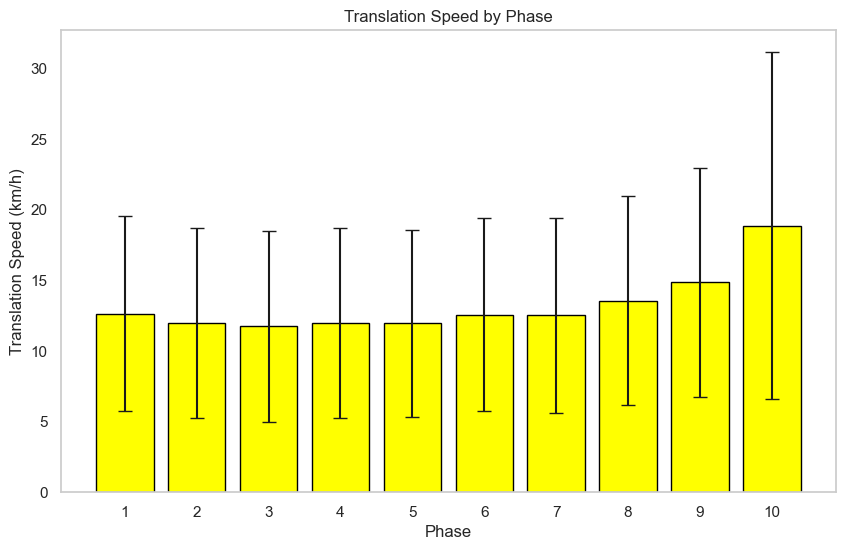

In [14]:
def plot_translationspeed(path_in, fig_out):
    data = pd.read_csv(path_in)
    cyclone_counts = data['No_cyclone'].value_counts()
    valid_cyclones = cyclone_counts[cyclone_counts >= 10].index
    filtered_data = data[data['No_cyclone'].isin(valid_cyclones)]

    def assign_phases(cyclone_df):
        n = len(cyclone_df)
        phases = pd.cut(range(n), bins=10, labels=False) + 1
        cyclone_df['phase'] = phases
        return cyclone_df

    phased_data = filtered_data.groupby('No_cyclone', group_keys=False).apply(assign_phases).reset_index(drop=True)

    def calculate_translation_speed(df):
        df = df.sort_values(by='Time')
        distances = [0]  # First entry has no previous point to calculate distance
        times = [0]  # First entry has no previous point to calculate time_diff

        for i in range(1, len(df)):
            coord1 = (df.iloc[i - 1]['lat_tenth'], df.iloc[i - 1]['lon_tenth'])
            coord2 = (df.iloc[i]['lat_tenth'], df.iloc[i]['lon_tenth'])
            distance = geodesic(coord1, coord2).kilometers
            time_diff = (pd.to_datetime(df.iloc[i]['Time'], format='%Y%m%d%H') -
                         pd.to_datetime(df.iloc[i - 1]['Time'], format='%Y%m%d%H')).total_seconds() / 3600  # hours
            distances.append(distance)
            times.append(time_diff)

        # Calculate speed
        speeds = [distances[i] / times[i] if times[i] > 0 else 0 for i in range(len(distances))]

        df['distance'] = distances
        df['time_diff'] = times
        df['translation_speed'] = speeds

        # Directly fill zeros with the average of the next two values
        for i in range(len(df) - 2):
            if df.iloc[i]['translation_speed'] == 0:
                df.at[df.index[i], 'translation_speed'] = (df.iloc[i + 1]['translation_speed'] + df.iloc[i + 2]['translation_speed']) / 2

        return df

    phased_data = phased_data.groupby('No_cyclone', group_keys=False).apply(calculate_translation_speed).reset_index(drop=True)

    phase_summary = phased_data.groupby('phase')['translation_speed'].agg(['mean', 'std']).reset_index()

    plt.figure(figsize=(10, 6))
    bars = plt.bar(phase_summary['phase'], phase_summary['mean'], yerr=phase_summary['std'], capsize=5, color='yellow',
                   edgecolor='black')
    plt.xlabel('Phase')
    plt.ylabel('Translation Speed (km/h)')
    plt.title('Translation Speed by Phase')
    plt.xticks(phase_summary['phase'])
    plt.grid(False)
    plt.savefig(fig_out, format='png', dpi=300)
    plt.show()

# use this function to generate translation speed
plot_translationspeed('D:/pythonfile/cyclone/Updated_South_indian_hurricane_with_SST.csv','D:/pythonfile/cyclone/figure/translation_speed.png')

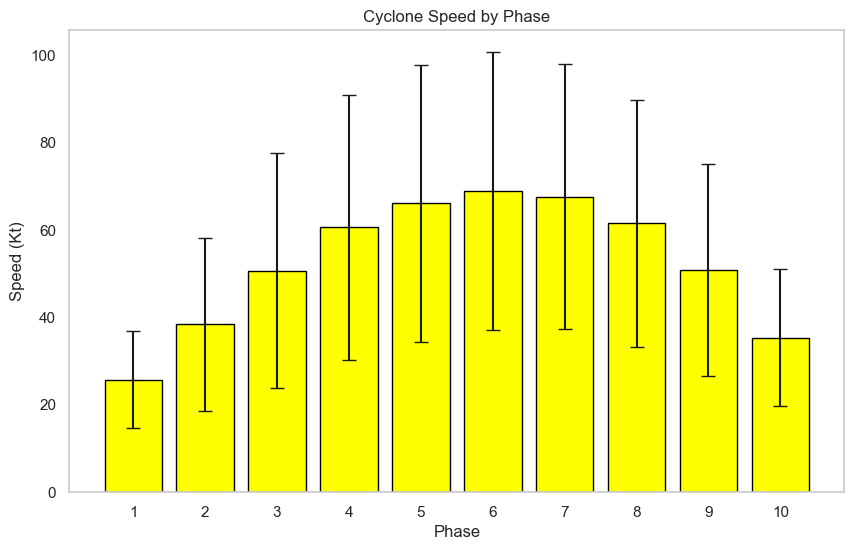

In [15]:
def plot_cyclone_speed(path_in,fig_out):
    data = pd.read_csv(path_in)
    cyclone_counts = data['No_cyclone'].value_counts()
    valid_cyclones = cyclone_counts[cyclone_counts >= 10].index
    filtered_data = data[data['No_cyclone'].isin(valid_cyclones)]

    def assign_phases(cyclone_df):
        n = len(cyclone_df)
        phases = pd.cut(range(n), bins=10, labels=False) + 1
        cyclone_df['phase'] = phases
        return cyclone_df

    phased_data = filtered_data.groupby('No_cyclone', group_keys=False).apply(assign_phases).reset_index(drop=True)
    phase_summary = phased_data.groupby('phase')['Speed(knots)'].agg(['mean', 'std']).reset_index()

    plt.figure(figsize=(10, 6))
    bars = plt.bar(phase_summary['phase'], phase_summary['mean'], yerr=phase_summary['std'], capsize=5, color='yellow',
                   edgecolor='black')
    plt.xlabel('Phase')
    plt.ylabel('Speed (Kt)')
    plt.title('Cyclone Speed by Phase')
    plt.xticks(phase_summary['phase'])
    plt.grid(False)
    plt.savefig(fig_out, format='png', dpi=300)
    plt.show()

# use this function to generate translation speed
plot_cyclone_speed('D:/pythonfile/cyclone/Updated_South_indian_hurricane_with_SST.csv','D:/pythonfile/cyclone/figure/cyclone_speed.png')

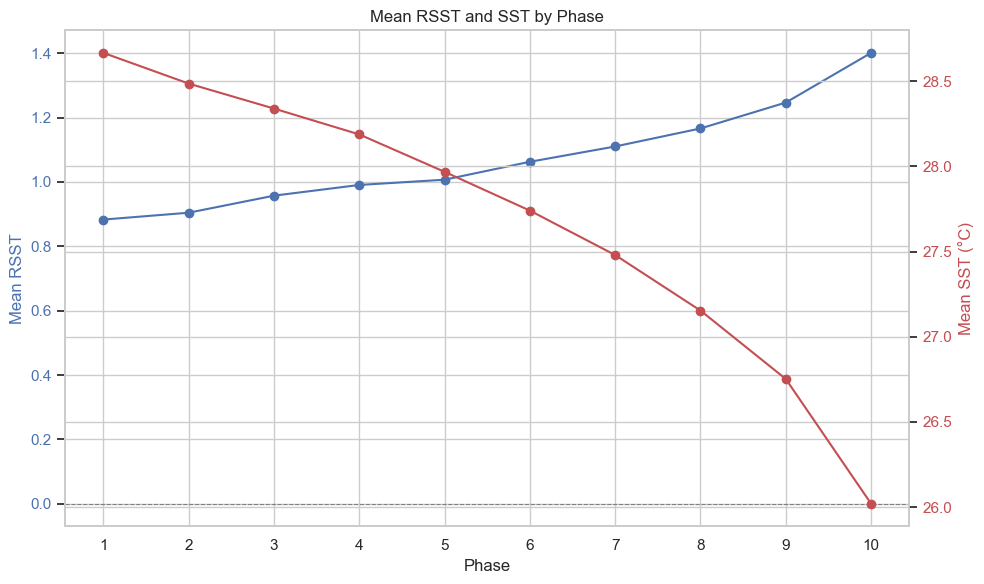

In [16]:
def plot_RSST_SST_phase(path_in, fig_out):
    data = pd.read_csv(path_in)
    cyclone_counts = data['No_cyclone'].value_counts()
    valid_cyclones = cyclone_counts[cyclone_counts >= 10].index
    filtered_data = data[data['No_cyclone'].isin(valid_cyclones)]

    def assign_phases(cyclone_df):
        n = len(cyclone_df)
        phases = pd.cut(range(n), bins=10, labels=False) + 1
        cyclone_df['phase'] = phases
        return cyclone_df

    # Remove rows where RSST column is NaN
    filtered_data = filtered_data.dropna(subset=['RSST'])

    # Assign phases
    phased_data = filtered_data.groupby('No_cyclone', group_keys=False).apply(assign_phases).reset_index(drop=True)

    # Calculate mean RSST for each phase
    phase_means_rsst = phased_data.groupby('phase')['RSST'].mean()

    # Adjust SST by subtracting 273.15 and calculate mean SST for each phase
    phased_data['SST'] = phased_data['SST'] - 273.15
    phase_means_sst = phased_data.groupby('phase')['SST'].mean()

    # Plot the results
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(phase_means_rsst.index, phase_means_rsst.values, marker='o', linestyle='-', color='b', label='Mean RSST')
    ax1.set_xlabel('Phase')
    ax1.set_xticks(range(1, 11))
    ax1.set_ylabel('Mean RSST', color='b')
    ax1.axhline(0, color='gray', linewidth=0.8, linestyle='--')  # Center the x-axis
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.plot(phase_means_sst.index, phase_means_sst.values, marker='o', linestyle='-', color='r',
             label='Mean SST')
    ax2.set_ylabel('Mean SST (°C)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title('Mean RSST and SST by Phase')
    fig.tight_layout()
    plt.grid(True)
    plt.savefig(fig_out, format='png', dpi=300)
    plt.show()

    
# use this function to generate RSST and SST during the 10 phases
plot_RSST_SST_phase('D:/pythonfile/cyclone/Updated_South_indian_hurricane_with_SST.csv','D:/pythonfile/cyclone/figure/RSST_SST_phase.png')